In [2]:
!pip install opensmile gdown transformers soundfile --quiet

### Accessing Dataset

In [3]:
import os
import tarfile
import tempfile
import re
from pathlib import Path
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torch
from tqdm import tqdm
import gdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import warnings
from transformers import logging, pipeline, DistilBertTokenizer, DistilBertModel

# suppress warnings and set transformer logging to error level
warnings.filterwarnings("ignore")
logging.set_verbosity_error()


# install dataset using gdown
!gdown 1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS

tarball_filename = "ADReSSo21-diagnosis-train.tar"

# extract contents from tarball
with tarfile.open(tarball_filename, 'r:*') as tar:
    tar.extractall(path="./")

# remove tarball after extraction
os.remove(tarball_filename)

Downloading...
From (original): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS
From (redirected): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS&confirm=t&uuid=6be30833-5786-4a3d-83a2-f63e40dc7fef
To: /content/ADReSSo21-diagnosis-train.tar
100% 1.75G/1.75G [00:33<00:00, 52.1MB/s]


### Helper Functions

In [24]:
def get_dataset_paths(dataset_root: str = "ADReSSo21/diagnosis/train"):
    # return paths for audio and segmentation folders based on the provided root
    dataset_dir = Path(dataset_root)
    return {
        "audio": dataset_dir / "audio",
        "audio_ad": dataset_dir / "audio" / "ad",
        "audio_cn": dataset_dir / "audio" / "cn",
        "segmentation": dataset_dir / "segmentation",
        "segmentation_ad": dataset_dir / "segmentation" / "ad",
        "segmentation_cn": dataset_dir / "segmentation" / "cn",
    }

def load_audio_file(file_path: Path):
    # load and return audio waveform and sampling rate from file
    return sf.read(file_path)

def load_segmentation(seg_file: Path):
    # load segmentation csv file into a DataFrame
    return pd.read_csv(seg_file)

def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    # extract and return patient speech segments from audio based on segmentation data
    patient_df = seg_df[seg_df["speaker"] == speaker]
    patient_mask = np.full_like(audio, np.nan)  # initialize array with nan
    segments_list = []
    segments = []
    for _, row in patient_df.iterrows():
        begin_sample = int(float(row["begin"]) * sr / 1000)
        end_sample = int(float(row["end"]) * sr / 1000)
        patient_mask[begin_sample:end_sample] = audio[begin_sample:end_sample]
        segments_list.append(audio[begin_sample:end_sample])
        segments.append((begin_sample, end_sample))
    concatenated = np.concatenate(segments_list) if segments_list else np.array([])
    return patient_mask, concatenated, segments

def process_audio(audio_file: Path, seg_file: Path, plot: bool = False):
    # process audio file and segmentation to extract patient-only segments; plot waveform if requested
    audio, sr = load_audio_file(audio_file)
    seg_df = load_segmentation(seg_file)
    patient_mask, concatenated, segments = extract_patient_segments(audio, sr, seg_df)
    if plot:
        time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
        plt.figure(figsize=(14, 4))
        plt.plot(time_axis, audio, label="Original")
        plt.plot(time_axis, patient_mask, label="Patient-Only")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("Patient Speech Isolation")
        plt.legend()
        plt.show()
    return audio, sr, patient_mask, concatenated, segments

def init_transcriber(model_name: str = "openai/whisper-large", device: int = 0):
    # initialize and return the ASR pipeline for transcription using the specified model and device
    return pipeline("automatic-speech-recognition", model=model_name, device=device)

def transcribe_audio_file(file_path: str, transcriber) -> str:
    # load audio from file, convert to mono if needed, and transcribe using provided transcriber
    data, sr = sf.read(file_path)
    if data.ndim > 1:
        data = librosa.to_mono(data.T)
    result = transcriber({"raw": data, "sampling_rate": sr, "language": "en"}, return_timestamps=True)
    return result.get("text", "")

def create_transcription_df(transcription_records: list) -> pd.DataFrame:
    # create and return a DataFrame from a list of transcription records
    return pd.DataFrame(transcription_records)


def transcribe_patient_only_audio(transcriber):
    # process audio files to extract patient-only segments, transcribe them, and save with labels (1 for ad, 0 for cn)
    paths = get_dataset_paths()
    results = []
    for group, label in [('ad', 1), ('cn', 0)]:
        if group == "ad":
            audio_dir = paths["audio_ad"]
            seg_dir = paths["segmentation_ad"]
        elif group == "cn":
            audio_dir = paths["audio_cn"]
            seg_dir = paths["segmentation_cn"]
        # sort audio files based on numeric order in filenames
        audio_files = sorted(list(audio_dir.glob("*.wav")),
                             key=lambda f: int(re.search(r'(\d+)', f.name).group(1)))
        for audio_file in tqdm(audio_files, desc=f"Transcribing patient-only for {group.upper()}"):
            seg_file = seg_dir / f"{audio_file.stem}.csv"
            audio, sr, patient_mask, concatenated, segments = process_audio(audio_file, seg_file, plot=False)
            if concatenated.size == 0:
                transcript = "No patient speech segments found."
            else:
                # write patient-only audio to temporary file, transcribe it, and then remove the temporary file
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
                    temp_filename = tmp_file.name
                sf.write(temp_filename, concatenated, sr)
                transcript = transcribe_audio_file(temp_filename, transcriber)
                os.remove(temp_filename)
            results.append({
                "file_name": audio_file.name,
                "transcription": transcript,
                "label": label
            })
    # sort results numerically and save to csv file
    results = sorted(results, key=lambda x: int(re.search(r'(\d+)', x["file_name"]).group(1)))
    df = create_transcription_df(results)
    df.to_csv("patient.csv", index=False)
    print("patient-only transcriptions saved to patient.csv")

def transcribe_full_audio(transcriber):
    # process full audio files (without segmentation), transcribe them, and save results with labels (1 for ad, 0 for cn)
    paths = get_dataset_paths()
    results = []
    for group, label in [('ad', 1), ('cn', 0)]:
        if group == "ad":
            audio_dir = paths["audio_ad"]
        elif group == "cn":
            audio_dir = paths["audio_cn"]
        # sort audio files based on numeric order in filenames
        audio_files = sorted(list(audio_dir.glob("*.wav")),
                             key=lambda f: int(re.search(r'(\d+)', f.name).group(1)))
        for audio_file in tqdm(audio_files, desc=f"Transcribing full audio for {group.upper()}"):
            transcript = transcribe_audio_file(str(audio_file), transcriber)
            results.append({
                "file_name": audio_file.name,
                "transcription": transcript,
                "label": label
            })
    # sort results numerically and save to csv file
    results = sorted(results, key=lambda x: int(re.search(r'(\d+)', x["file_name"]).group(1)))
    df = create_transcription_df(results)
    df.to_csv("all.csv", index=False)
    print("full audio transcriptions saved to all.csv")

def load_transcript_data(csv_file: str):
    # load transcript data from csv; return lists of transcripts and labels
    df = pd.read_csv(csv_file)
    transcripts = df["transcription"].tolist()
    labels = df["label"].tolist()
    return transcripts, labels

def get_feature_vector(transcript: str, tokenizer, model):
    # tokenize transcript, pass it through the model, and return mean-pooled feature vector
    inputs = tokenizer(transcript, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    pooled_feature = outputs.last_hidden_state.mean(dim=1)  # mean pooling over sequence dimension
    return pooled_feature.squeeze(0)  # return 1D tensor of shape (hidden_size,)

def process_csv_to_features(csv_file: str, tokenizer, model):
    # process all transcripts in csv to obtain feature vectors and labels; return as numpy arrays
    transcripts, labels = load_transcript_data(csv_file)
    feature_list = []
    for transcript in transcripts:
        feature_vec = get_feature_vector(transcript, tokenizer, model)
        feature_list.append(feature_vec.detach().cpu().numpy())
    features = np.stack(feature_list)  # shape: (num_transcripts, hidden_size)
    labels = np.array(labels)
    return features, labels


def load_feature_data():
    # load and return feature vectors and labels for patient-only and full audio from npy files
    patient_features = np.load("patient_features.npy")
    patient_labels = np.load("patient_labels.npy")
    full_features = np.load("all_features.npy")
    full_labels = np.load("all_labels.npy")
    return (patient_features, patient_labels), (full_features, full_labels)

def split_data(features, labels, test_size=0.2, random_state=42):
    # split data into training and testing sets using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    return X_train, X_test, y_train, y_test


def get_classifiers():
    # return dictionary of classifier instances with preset hyperparameters
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=2000, solver="lbfgs"),
        "DecisionTree":          DecisionTreeClassifier(),
        "RandomForest":          RandomForestClassifier(),
        "XGBoost":               XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
        "MLP":                   MLPClassifier(max_iter=200, early_stopping=True, n_iter_no_change=10)
    }
    return classifiers

def train_and_evaluate(X_train, X_test, y_train, y_test, classifiers):
    # train each classifier and evaluate accuracy on test set; return results dictionary
    results = {}
    for name, clf in classifiers.items():
        model = clone(clf)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
    return results


def plot_results(results_patient, results_full):
    # plot grouped bar chart comparing accuracies for patient-only and full audio feature sets
    model_names = list(results_patient.keys())
    n_models = len(model_names)
    acc_patient = [results_patient[m] * 100 for m in model_names]
    acc_full    = [results_full[m] * 100 for m in model_names]

    x = np.arange(n_models)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - bar_width/2, acc_patient, width=bar_width, label="Patient-Only")
    rects2 = ax.bar(x + bar_width/2, acc_full, width=bar_width, label="Full Audio")

    ax.set_ylabel("Accuracy (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_title("Classifier Accuracy: Patient-Only vs. Full Audio Features")
    ax.legend()

    # annotate bars with accuracy values
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom")
    plt.tight_layout()
    plt.show()

def display_results_table(results_patient, results_full):
    # display a formatted table comparing classifier accuracies for both feature sets
    headers = ["Model", "Patient-Only Accuracy", "Full Audio Accuracy"]
    table_data = []
    for model in results_patient.keys():
        table_data.append([
            model,
            f"{results_patient[model] * 100:.2f}%",
            f"{results_full[model] * 100:.2f}%"
        ])
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))

### Transcription


In [21]:
device = 0
model_name = "openai/whisper-large"
transcriber = init_transcriber(model_name=model_name, device=device)

# transcribe patient-only audio and save to patient.csv
transcribe_patient_only_audio(transcriber)

Transcribing patient-only for CN: 100%|██████████| 79/79 [06:48<00:00,  5.17s/it]

Patient-only transcriptions saved to patient.csv


In [23]:
device = 0  # Use GPU (device index 0) if available
model_name = "openai/whisper-large"
transcriber = init_transcriber(model_name=model_name, device=device)

# transcribe full audio and save to all.csv
transcribe_full_audio(transcriber)

Transcribing full audio for CN: 100%|██████████| 79/79 [07:46<00:00,  5.90s/it]

Full audio transcriptions saved to all.csv


### Feature Extraction

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# process the patient.csv file (which has patient-only transcripts from both classes)
patient_features, patient_labels = process_csv_to_features("patient.csv", tokenizer, model)
print("Patient features shape:", patient_features.shape)
print("Patient labels shape:", patient_labels.shape)

# save the feature vectors and labels as NumPy files for future use.
np.save("patient_features.npy", patient_features)
np.save("patient_labels.npy", patient_labels)
print("Saved patient_features.npy and patient_labels.npy")

# process the all.csv file (which has the full audio transcripts)
all_features, all_labels = process_csv_to_features("all.csv", tokenizer, model)
print("All features shape:", all_features.shape)
print("All labels shape:", all_labels.shape)

# save the feature vectors and labels as NumPy files for future use.
np.save("all_features.npy", all_features)
np.save("all_labels.npy", all_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Patient features shape: (166, 768)
Patient labels shape: (166,)
Saved patient_features.npy and patient_labels.npy
All features shape: (166, 768)
All labels shape: (166,)


### Training

In [26]:
(patient_features, patient_labels), (full_features, full_labels) = load_feature_data()
print("Patient features shape:", patient_features.shape)
print("Patient labels shape:", patient_labels.shape)
print("Full audio features shape:", full_features.shape)
print("Full audio labels shape:", full_labels.shape)

# split each dataset into training and test sets.
X_train_patient, X_test_patient, y_train_patient, y_test_patient = split_data(patient_features, patient_labels)
X_train_full, X_test_full, y_train_full, y_test_full = split_data(full_features, full_labels)

classifiers = get_classifiers()

# train and evaluate classifiers on patient-only features.
results_patient = train_and_evaluate(X_train_patient, X_test_patient, y_train_patient, y_test_patient, classifiers)

# train and evaluate classifiers on full audio features.
results_full = train_and_evaluate(X_train_full, X_test_full, y_train_full, y_test_full, classifiers)

Patient features shape: (166, 768)
Patient labels shape: (166,)
Full audio features shape: (166, 768)
Full audio labels shape: (166,)


In [27]:
display_results_table(results_patient, results_full)

+--------------------+-----------------------+---------------------+
|       Model        | Patient-Only Accuracy | Full Audio Accuracy |
+--------------------+-----------------------+---------------------+
| LogisticRegression |        79.41%         |       82.35%        |
|    DecisionTree    |        61.76%         |       82.35%        |
|    RandomForest    |        79.41%         |       76.47%        |
|      XGBoost       |        85.29%         |       79.41%        |
|        MLP         |        85.29%         |       82.35%        |
+--------------------+-----------------------+---------------------+


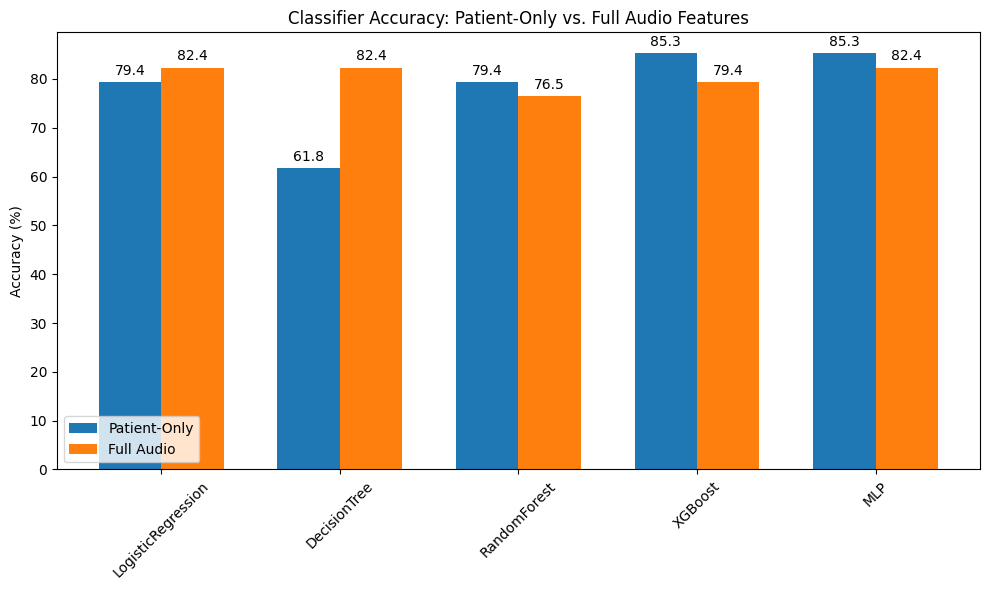

In [28]:
plot_results(results_patient, results_full)